This notebook for plotting tracer transport and budget diagnsotics for NAO-based composites.

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import xmip.preprocessing as xmip
import glob
import xskillscore as xs

import matplotlib.image as image
import matplotlib.patches as patches

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

## Figure: Overturning and tracer transport anomalies

In [3]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['thetao', 'dissic']

ds = []
for var in var_list:
    d = xr.open_dataset(ppdir + "all_ensembles/Timeseries/" + var + "_Transport_Atlantic.nc")
    d = d.drop('time').assign_coords(time=d['time.year'] + d['time.month']/12 - 1902)
    d = d.assign_coords(lat=d['latitude'].values)
    ds.append(d)

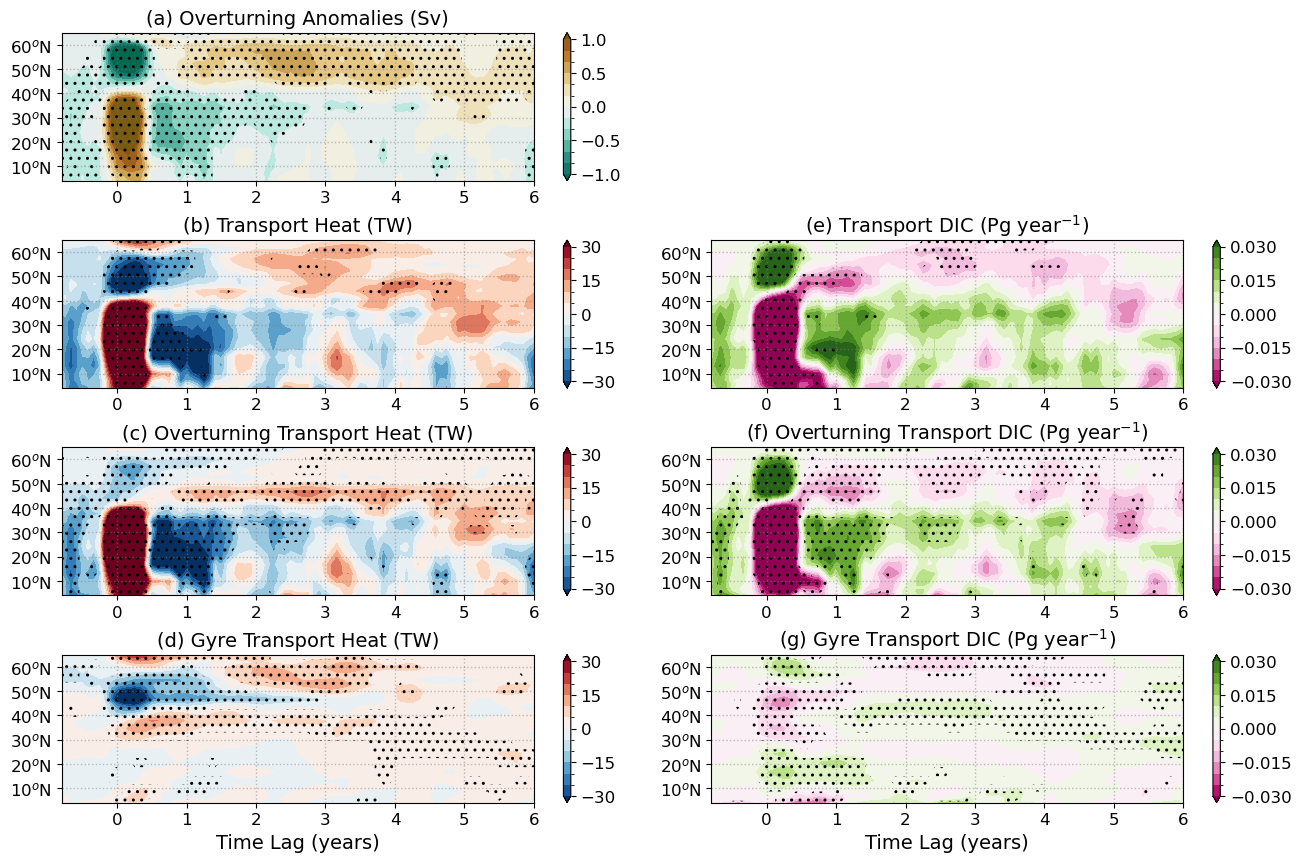

In [4]:
grid1 = plt.GridSpec(4, 2, wspace=0.1, hspace=0.4)
fig = plt.figure(figsize=[16,10])

hatch_dense = 2
fac = [1.e12, 1.e15/(12*3600*24*365)] # convert heat transport to TW and DIC transport to Pg/year
lim_vmax = [30., 0.03]
cb_map = [cmaps.MPL_RdBu_r, cmaps.MPL_PiYG]
titl_list = ['Heat (TW)', r'DIC (Pg year$^{-1}$)']
          
for i in range(0,2):
    if(i==0):
        ax = fig.add_subplot(grid1[i, 0])
        tmp = ds[i]['Overturning_z'].isel(lev=45)/1.e6
        tmp_cfd = (ds[i]['Overturning_z_confidence_upper'] - 
                   ds[i]['Overturning_z_confidence_lower']).isel(lev=45) * 0.5/1.e6 # in Sv
        p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -1., vmax = 1.,
                          cmap=cmaps.NEO_div_vegetation_c_r, add_labels=False, add_colorbar=False, extend='both')
        ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
        ax.set_xlim([-0.8, 6.]);
        ax.set_ylim([4., 65.]);
        ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
        plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                         r'$50^o$N', r'$60^o$N'], fontsize = 12);
        plt.xticks(fontsize = 12);
        cb = fig.colorbar(p, ax=ax, ticks=[-1, -0.5, 0, 0.5, 1], extend='both')
        cb.ax.tick_params(labelsize=12)
        ax.set_title('(a) Overturning Anomalies (Sv)', fontsize=14)

    # overturning tracer transport
    ax = fig.add_subplot(grid1[2,i])
    tmp = ds[i][var_list[i] + '_Transport_overturning']/fac[i]
    tmp_cfd = (ds[i][var_list[i] + '_Transport_overturning_confidence_upper'] - 
               ds[i][var_list[i] + '_Transport_overturning_confidence_lower']) * 0.5/fac[i]
    p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax[i], vmax = lim_vmax[i],
                      cmap=cb_map[i], add_labels=False, add_colorbar=False, extend='both')
    ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                levels=[.5,1.,1.5,2.], hatches=[hatch_dense*'.'])
    cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax[i], -lim_vmax[i]/2, 0, lim_vmax[i]/2., lim_vmax[i]], extend='both')
    cb.ax.tick_params(labelsize=12)
    ax.set_xlim([-0.8, 6.]);
    ax.set_ylim([4., 65.]);
    ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
    plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                     r'$50^o$N', r'$60^o$N'], fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_title('(' + chr(97+3*i+2) + ') Overturning Transport ' + titl_list[i], fontsize=14)
    
    # gyre tracer transport
    ax = fig.add_subplot(grid1[3,i])
    tmp = ds[i][var_list[i] + '_Transport_gyre']/fac[i] # in PW
    tmp_cfd = (ds[i][var_list[i] + '_Transport_gyre_confidence_upper'] - 
               ds[i][var_list[i] + '_Transport_gyre_confidence_lower']) * 0.5/fac[i]
    p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax[i], vmax = lim_vmax[i],
                      cmap=cb_map[i], add_labels=False, add_colorbar=False, extend='both')
    ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax[i], -lim_vmax[i]/2, 0, lim_vmax[i]/2., lim_vmax[i]], extend='both')
    cb.ax.tick_params(labelsize=12)
    ax.set_xlim([-0.8, 6.]);
    ax.set_ylim([4., 65.]);
    ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
    plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                     r'$50^o$N', r'$60^o$N'], fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_xlabel('Time Lag (years)', fontsize=14)
    ax.set_title('(' + chr(97+3*i+3) + ') Gyre Transport ' + titl_list[i], fontsize=14)

    # Total tracer transport
    ax = fig.add_subplot(grid1[1,i])
    tmp = ds[i][var_list[i] + '_Transport']/fac[i]
    tmp_cfd = (ds[i][var_list[i] + '_Transport_confidence_upper'] - 
               ds[i][var_list[i] + '_Transport_confidence_lower'])/fac[i]
    p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax[i], vmax = lim_vmax[i],
                      cmap=cb_map[i], add_labels=False, add_colorbar=False, extend='both')
    ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    ax.set_xlim([-0.8, 6.]);
    ax.set_ylim([4., 65.]);
    ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
    plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                     r'$50^o$N', r'$60^o$N'], fontsize = 12);
    plt.xticks(fontsize = 12);
    cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax[i], -lim_vmax[i]/2, 0, lim_vmax[i]/2., lim_vmax[i]], extend='both')
    cb.ax.tick_params(labelsize=12)
    ax.set_title('(' + chr(97+3*i+1) + ') Transport ' + titl_list[i], fontsize=14)

#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Transport.pdf', 
#            dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Transport.png', 
#            dpi=300,bbox_inches='tight');

## Figure: Heat and DIC budget

In [3]:
# upper 100 m budgets

ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['thetao', 'dissic']

ds = []
for var in var_list:
    d = xr.open_dataset(ppdir + "all_ensembles/Timeseries/" + var + "_Budget_new_regions_2_depth_100.nc")
    d = d.drop('time').assign_coords(time=d['time.year'] + d['time.month']/12 - 1902 + 6./12)
    ds.append(d)

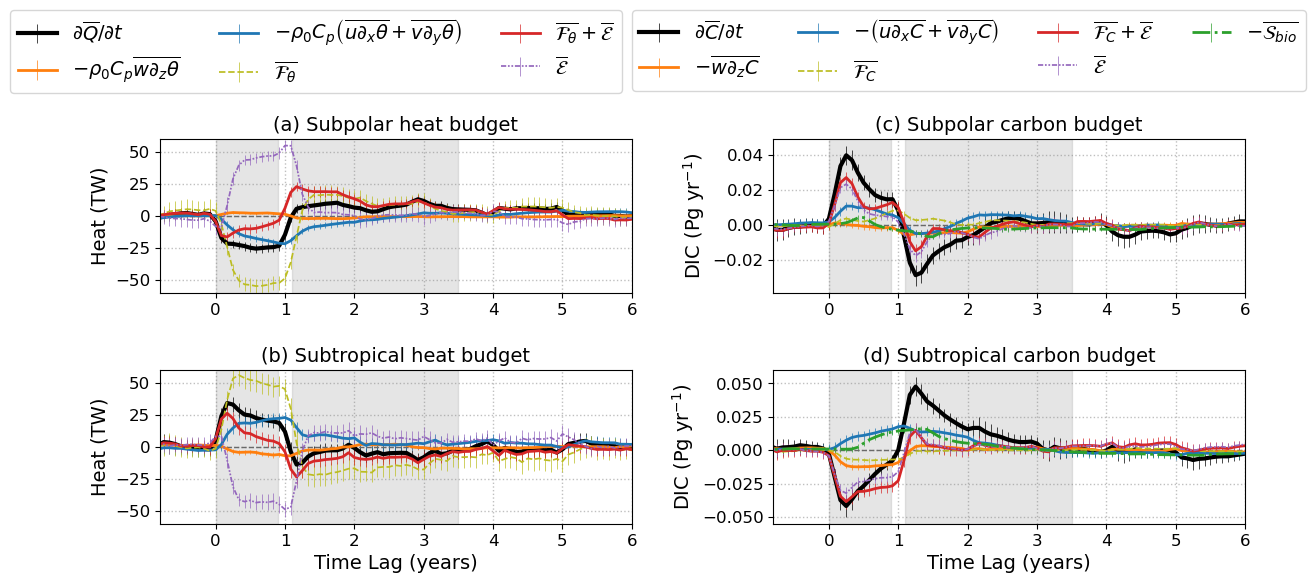

In [6]:
region_list = ['_North_Atlantic_Subpolar', '_North_Atlantic_Subtropical']
reg_lab = [r'Subpolar', r'Subtropical']


fac = [1./1e12, 1000. * 1.e-15 * 3600*24*365] # convert heat budget in terawatts (from watts) and DIC budget in Pg/year (from kg/s)

label_tend = [r'${\partial \overline{Q}/\partial t}$', r'${\partial \overline{C}/\partial t}$']
label_hor = [r'$-\rho_0C_p\left(\overline{u\partial_x\theta} + \overline{v\partial_y\theta} \right)$',
             r'$-\left(\overline{u\partial_xC} + \overline{v\partial_yC} \right)$']
label_ver = [r'$-\rho_0C_p\overline{w\partial_z\theta}$',
             r'$-\overline{w\partial_zC}$']

grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)
fig = plt.figure(figsize=[14,5])

for i in range(0,2):
    j = 0
    for region in region_list:
        ax = fig.add_subplot(grid1[j, i])
        # 95% confidence interval (+- yerr = (upper-bound -lower_bound)*0.5 = 2*standard_error)
        ax.errorbar(ds[i]['time'], ds[i]['dt_' + var_list[i] + region]* fac[i], 
                    yerr = (ds[i]['dt_' + var_list[i] + region + '_confidence_upper'] 
                            - ds[i]['dt_' + var_list[i] + region + '_confidence_lower'])* fac[i]*0.5, #0.5 factor proper errorbars
                    lw=3.0, elinewidth=0.5, label= label_tend[i], color='black')
        
        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_ver_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_ver_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_ver_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_ver[i], color='tab:orange')

        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_hor_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_hor_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_hor_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_hor[i], color='tab:blue')

            
        if(i==0):
            ax.errorbar(ds[i]['time'], ds[i]['hfds' + region]* fac[i], 
                        yerr = (ds[i]['hfds' + region + '_confidence_upper'] - 
                                ds[i]['hfds' + region + '_confidence_lower'])* fac[i]*0.5, color='tab:olive',
                        lw=1.25, elinewidth=0.5, ls='--', label= r'$\overline{\mathcal{F}_{\theta}}$') 

            tmp = ds[i][var_list[i]+'_vert_flx_conv'+ region] * fac[i]
            
            ax.errorbar(ds[i]['time'], tmp, lw=2., 
                        yerr = (ds[i][var_list[i]+'_vert_flx_conv' + region + '_confidence_upper'] - 
                                ds[i][var_list[i]+'_vert_flx_conv' + region + '_confidence_lower'])* fac[i]*0.5,
                        elinewidth=0.5, color='tab:red', 
                        label=r'$\overline{\mathcal{F}_{\theta}} + \overline{\mathcal{E}}$')
            
            ax.errorbar(ds[i]['time'], ds[i][var_list[i]+ '_res' + region]* fac[i], 
                        yerr = (ds[i][var_list[i]+ '_res' + region + '_confidence_upper'] -
                                ds[i][var_list[i]+ '_res' + region + '_confidence_lower'])* fac[i]*0.5, ls=(0, (3, 1, 1, 1,1, 1)), 
                        lw=1.25, elinewidth=0.5, label=r'$\overline{\mathcal{E}}$', color='tab:purple')
            
            if(j==1):
                plt.legend(loc='upper right', bbox_to_anchor=(1., 3.4), ncol=3, fontsize=14);
                
        else:
            ax.errorbar(ds[i]['time'], ds[i]['fgco2' + region]* fac[i], 
                        yerr = (ds[i]['fgco2' + region + '_confidence_upper'] - 
                                ds[i]['fgco2' + region + '_confidence_lower'])* fac[i]*0.5, color='tab:olive',
                        lw=1.25, elinewidth=0.5, ls='--', label= r'$\overline{\mathcal{F}_{C}}$')

            tmp = ds[i][var_list[i]+'_vert_flx_conv'+ region] * fac[i]
            
            ax.errorbar(ds[i]['time'], tmp, lw=2., 
                        yerr = (ds[i][var_list[i]+'_vert_flx_conv' + region + '_confidence_upper'] - 
                                ds[i][var_list[i]+'_vert_flx_conv' + region + '_confidence_lower'])* fac[i]*0.5,
                        elinewidth=0.5, color='tab:red',
                        label=r'$\overline{\mathcal{F}_{C}} + \overline{\mathcal{E}}$')
            
            ax.errorbar(ds[i]['time'], ds[i][var_list[i]+ '_res_bio' + region]* fac[i], color='tab:purple',
                        yerr = (ds[i][var_list[i]+ '_res_bio' + region + '_confidence_upper'] -
                                ds[i][var_list[i]+ '_res_bio' + region + '_confidence_lower'])* fac[i]*0.5, 
                        ls=(0, (3, 1, 1, 1,1, 1)), 
                        lw=1.25, elinewidth=0.5, label=r'$\overline{\mathcal{E}}$')
            
            ax.errorbar(ds[i]['time'], ds[i]['particulate_flux' + region]* fac[i], 
                        yerr = (ds[i]['particulate_flux' + region + '_confidence_upper'] -
                                ds[i]['particulate_flux' + region + '_confidence_lower'])* fac[i]*0.5, ls='-.', 
                        lw=2., elinewidth=0.5, label=r'$-\overline{\mathcal{S}_{bio}}$', color='tab:green')
            
            if(j==1):
                plt.legend(loc='upper right', bbox_to_anchor=(1.15, 3.4), ncol=4, fontsize=14);
            
        ax.set_xlim([-0.8, 6.]);
        plt.xticks(fontsize = 12); plt.yticks(fontsize = 12);
        ax.axhline(y=0, ls='--', lw=1, color='dimgrey')
        ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
        ax.axvspan(0., 0.9, alpha=0.2, color='gray')
        ax.axvspan(1.1, 3.5, alpha=0.2, color='gray')
        
        if(j==1):
            ax.set_xlabel('Time Lag (years)', fontsize=14)
            #plt.legend(loc='upper right', bbox_to_anchor=(1.0, 3.6), ncol=3, fontsize=14);

        if(i==0):
            ax.set_ylabel('Heat (TW)', fontsize=14)
            ax.set_ylim([-60., 60.]);
            plt.yticks(np.arange(-50,60,25))
            ax.set_title('(' + chr(97+j) + ') ' + reg_lab[j] + ' heat budget', fontsize=14)
        else:
            ax.set_ylabel(r'DIC (Pg yr$^{-1}$)', fontsize=14)
            #ax.set_ylim([-0.05, 0.05]);
            #plt.yticks(np.arange(-0.04,0.05,0.02))
            ax.set_title('(' + chr(99+j) + ') ' + reg_lab[j] + ' carbon budget', fontsize=14)
        
        j = j + 1

fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Budget.pdf', 
            dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Budget.png', 
            dpi=300,bbox_inches='tight');


In [47]:
# budget in upper 1 km

ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['thetao', 'dissic']

ds = []
for var in var_list:
    d = xr.open_dataset(ppdir + "all_ensembles/Timeseries/" + var + "_Budget_new_regions_2_depth_1000.nc")
    d = d.drop('time').assign_coords(time=d['time.year'] + d['time.month']/12 - 1902 + 6./12)
    ds.append(d)

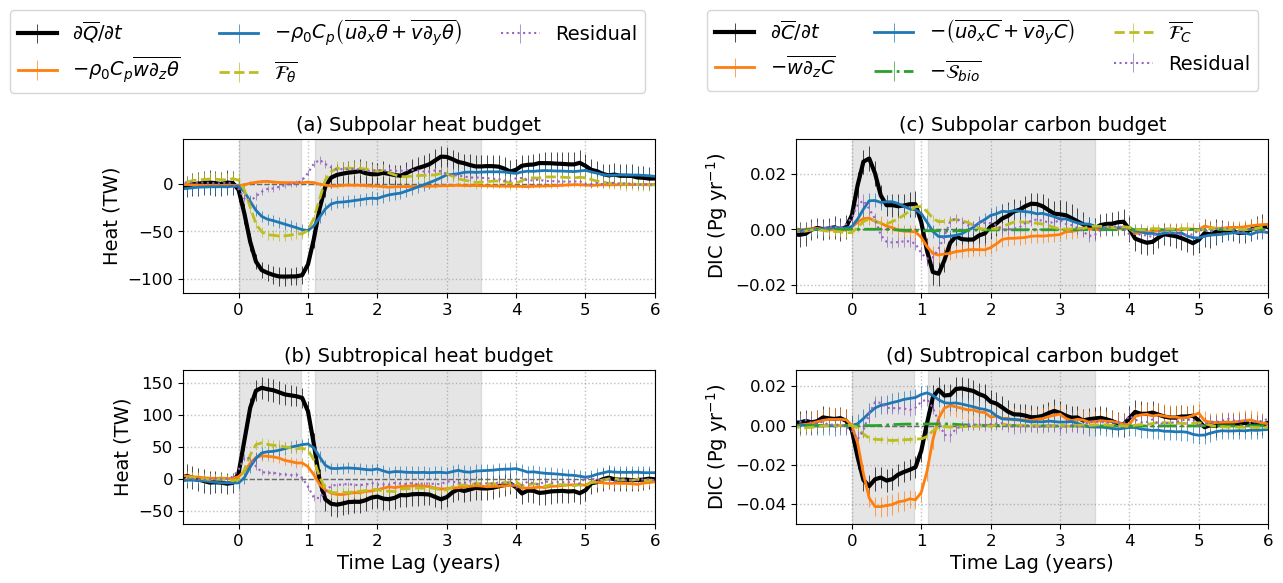

In [48]:
# 1000 m 

region_list = ['_North_Atlantic_Subpolar', '_North_Atlantic_Subtropical']
reg_lab = [r'Subpolar', r'Subtropical']


fac = [1./1e12, 1000. * 1.e-15 * 3600*24*365] # convert heat budget in terawatts (from watts) and DIC budget in Pg/year (from kg/s)

label_tend = [r'${\partial \overline{Q}/\partial t}$', r'${\partial \overline{C}/\partial t}$']
label_hor = [r'$-\rho_0C_p\left(\overline{u\partial_x\theta} + \overline{v\partial_y\theta} \right)$',
             r'$-\left(\overline{u\partial_xC} + \overline{v\partial_yC} \right)$']
label_ver = [r'$-\rho_0C_p\overline{w\partial_z\theta}$',
             r'$-\overline{w\partial_zC}$']

grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)
fig = plt.figure(figsize=[14,5])

for i in range(0,2):
    j = 0
    for region in region_list:
        ax = fig.add_subplot(grid1[j, i])
        ax.errorbar(ds[i]['time'], ds[i]['dt_' + var_list[i] + region]* fac[i], 
                    yerr = (ds[i]['dt_' + var_list[i] + region + '_confidence_upper'] 
                            - ds[i]['dt_' + var_list[i] + region + '_confidence_lower'])* fac[i]*0.5, #0.5 factor proper errorbars
                    lw=3., elinewidth=0.5, label= label_tend[i], color='black')
        
        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_ver_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_ver_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_ver_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_ver[i], color='tab:orange')
        
        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_hor_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_hor_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_hor_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_hor[i], color='tab:blue')

        if(i==1):
            ax.errorbar(ds[i]['time'], ds[i]['particulate_flux' + region]* fac[i], 
                        yerr = (ds[i]['particulate_flux' + region + '_confidence_upper'] -
                                ds[i]['particulate_flux' + region + '_confidence_lower'])* fac[i]*0.5, ls='-.', 
                        lw=2., elinewidth=0.5, label=r'$-\overline{\mathcal{S}_{bio}}$', color='tab:green')
        
        if(i==0):
            ax.errorbar(ds[i]['time'], ds[i]['hfds' + region]* fac[i], 
                        yerr = (ds[i]['hfds' + region + '_confidence_upper'] - 
                                ds[i]['hfds' + region + '_confidence_lower'])* fac[i]*0.5, color='tab:olive',
                        lw=2., elinewidth=0.5, ls='--', label= r'$\overline{\mathcal{F}_{\theta}}$') 
            # 95% confidence interval (+- yerr = (upper-bound -lower_bound)*0.5 = 2*standard_error)
        else:
            ax.errorbar(ds[i]['time'], ds[i]['fgco2' + region]* fac[i], 
                        yerr = (ds[i]['fgco2' + region + '_confidence_upper'] - 
                                ds[i]['fgco2' + region + '_confidence_lower'])* fac[i]*0.5, color='tab:olive',
                        lw=2., elinewidth=0.5, ls='--', label= r'$\overline{\mathcal{F}_{C}}$')
            

        ax.errorbar(ds[i]['time'], ds[i][var_list[i]+ '_res' + region]* fac[i], 
                    yerr = (ds[i][var_list[i]+ '_res' + region + '_confidence_upper'] -
                            ds[i][var_list[i]+ '_res' + region + '_confidence_lower'])* fac[i]*0.5, ls=':', 
                    lw=1.5, elinewidth=0.5, label='Residual', color='tab:purple')


        ax.set_xlim([-0.8, 6.]);
        plt.xticks(fontsize = 12); plt.yticks(fontsize = 12);
        ax.axhline(y=0, ls='--', lw=1, color='dimgrey')
        ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
        ax.axvspan(0., 0.9, alpha=0.2, color='gray')
        ax.axvspan(1.1, 3.5, alpha=0.2, color='gray')
        
        if(j==1):
            ax.set_xlabel('Time Lag (years)', fontsize=14)
            plt.legend(loc='upper right', bbox_to_anchor=(1.0, 3.4), ncol=3, fontsize=14);

        if(i==0):
            ax.set_ylabel('Heat (TW)', fontsize=14)
            #ax.set_ylim([-60., 60.]);
            #plt.yticks(np.arange(-50,60,25))
            ax.set_title('(' + chr(97+j) + ') ' + reg_lab[j]+ ' heat budget', fontsize=14)
        else:
            ax.set_ylabel(r'DIC (Pg yr$^{-1}$)', fontsize=14)
            #ax.set_ylim([-0.05, 0.05]);
            #plt.yticks(np.arange(-0.04,0.05,0.02))
            ax.set_title('(' + chr(99+j) + ') ' + reg_lab[j]+ ' carbon budget', fontsize=14)
        
        j = j + 1

fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Budget_1km.pdf', 
            dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_Budget_1km.png', 
            dpi=300,bbox_inches='tight');

### Figure: PO4 budget

In [51]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['po4']

ds = []
for var in var_list:
    d = xr.open_dataset(ppdir + "all_ensembles/Timeseries/" + var + "_Budget_new_regions_2_depth_100.nc")
    d = d.drop('time').assign_coords(time=d['time.year'] + d['time.month']/12 - 1902 + 6./12)
    ds.append(d)

ds1 = xr.open_dataset(ppdir + "all_ensembles/Timeseries/po4_Transport_Atlantic.nc")
ds1 = ds1.drop('time').assign_coords(time=ds1['time.year'] + ds1['time.month']/12 - 1902)
ds1 = ds1.assign_coords(lat=ds1['latitude'].values)

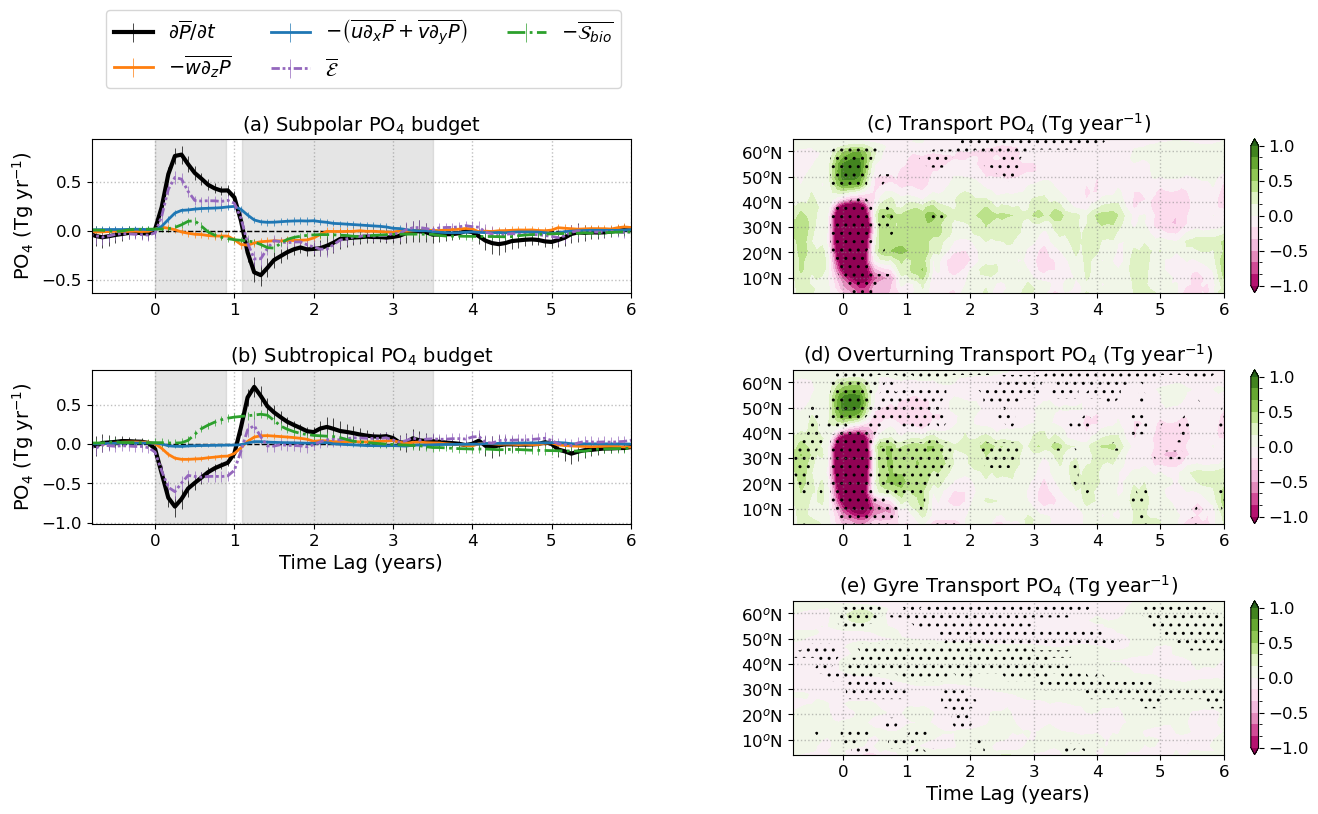

In [52]:
region_list = ['_North_Atlantic_Subpolar', '_North_Atlantic_Subtropical']
reg_lab = [r'Subpolar', r'Subtropical']


fac = [1000. * 1.e-12 * 3600*24*365] # convert po4 budget in Pg/year (from kg/s)

label_tend = [r'${\partial \overline{P}/\partial t}$']
label_hor = [r'$-\left(\overline{u\partial_xP} + \overline{v\partial_yP} \right)$']
label_ver = [r'$-\overline{w\partial_zP}$']

grid1 = plt.GridSpec(3,2, wspace=0.3, hspace=0.5)
fig = plt.figure(figsize=[16,8])

for i in range(0,1):
    j = 0
    for region in region_list:
        ax = fig.add_subplot(grid1[j, i])
        ax.errorbar(ds[i]['time'], ds[i]['dt_' + var_list[i] + region]* fac[i], 
                    yerr = (ds[i]['dt_' + var_list[i] + region + '_confidence_upper'] 
                            - ds[i]['dt_' + var_list[i] + region + '_confidence_lower'])* fac[i]*0.5, #0.5 factor proper errorbars
                    lw=3., elinewidth=0.5, label= label_tend[i], color='black')
        
        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_ver_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_ver_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_ver_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_ver[i], color='tab:orange')
        ax.errorbar(ds[i]['time'], ds[i][var_list[i] + '_hor_div' + region]* fac[i], 
                    yerr = (ds[i][var_list[i] + '_hor_div' + region + '_confidence_upper'] -
                           ds[i][var_list[i] + '_hor_div' + region + '_confidence_lower'])* fac[i] * 0.5, 
                    lw=2., elinewidth=0.5, label= label_hor[i], color='tab:blue')


        ax.errorbar(ds[i]['time'], ds[i][var_list[i]+ '_res_bio' + region]* fac[i], 
                    yerr = (ds[i][var_list[i]+ '_res_bio' + region + '_confidence_upper'] -
                            ds[i][var_list[i]+ '_res_bio' + region + '_confidence_lower'])* fac[i]*0.5, ls=(0, (3, 1, 1, 1,1, 1)), 
                    lw=2., elinewidth=0.5, label=r'$\overline{\mathcal{E}}$', color='tab:purple')
        ax.errorbar(ds[i]['time'], ds[i]['particulate_flux' + region]* fac[i], 
                    yerr = (ds[i]['particulate_flux' + region + '_confidence_upper'] -
                            ds[i]['particulate_flux' + region + '_confidence_lower'])* fac[i]*0.5, ls='-.', 
                    lw=2., elinewidth=0.5, label=r'$-\overline{\mathcal{S}_{bio}}$', color='tab:green')

        ax.set_xlim([-0.8, 6.]);
        plt.xticks(fontsize = 12); plt.yticks(fontsize = 12);
        ax.axhline(y=0, ls='--', lw=1, color='k')
        ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
        ax.axvspan(0., 0.9, alpha=0.2, color='gray')
        ax.axvspan(1.1, 3.5, alpha=0.2, color='gray')
        
        if(j==1):
            ax.set_xlabel('Time Lag (years)', fontsize=14)
            plt.legend(loc='upper right', bbox_to_anchor=(1.0, 3.4), ncol=3, fontsize=14);


        ax.set_ylabel(r'PO$_4$ (Tg yr$^{-1}$)', fontsize=14)
        #ax.set_ylim([-0.05, 0.05]);
        #plt.yticks(np.arange(-0.04,0.05,0.02))
        ax.set_title('(' + chr(97+j) + ') ' + reg_lab[j] + ' PO$_4$ budget', fontsize=14)
        
        j = j + 1


# overturning tracer transport
fac = 1.e12/(31*3600*24*365) # convert to Tera-gm/year
lim_vmax = 1.0
cb_map = cmaps.MPL_PiYG
titl_list = r'PO$_4$ (Tg year$^{-1}$)'
hatch_dense = 2

ax = fig.add_subplot(grid1[1,1])
tmp = ds1['po4_Transport_overturning']/fac
tmp_cfd = (ds1['po4_Transport_overturning_confidence_upper'] - 
           ds1['po4_Transport_overturning_confidence_lower']) * 0.5/fac
p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax, vmax = lim_vmax,
                      cmap=cb_map, add_labels=False, add_colorbar=False, extend='both')
ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
            levels=[.5,1.,1.5,2.], hatches=[hatch_dense*'.'])
cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax, -lim_vmax/2, 0, lim_vmax/2., lim_vmax], 
                                   extend='both')
cb.ax.tick_params(labelsize=12)
ax.set_xlim([-0.8, 6.]);
ax.set_ylim([4., 65.]);
ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                r'$50^o$N', r'$60^o$N'], fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_title('(d) Overturning Transport ' + titl_list, fontsize=14)
    
# gyre tracer transport
ax = fig.add_subplot(grid1[2,1])
tmp = ds1['po4_Transport_gyre']/fac # in PW
tmp_cfd = (ds1['po4_Transport_gyre_confidence_upper'] - 
            ds1['po4_Transport_gyre_confidence_lower']) * 0.5/fac
p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax, vmax = lim_vmax,
                      cmap=cb_map, add_labels=False, add_colorbar=False, extend='both')
ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax, -lim_vmax/2, 0, lim_vmax/2., lim_vmax], extend='both')
cb.ax.tick_params(labelsize=12)
ax.set_xlim([-0.8, 6.]);
ax.set_ylim([4., 65.]);
ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                r'$50^o$N', r'$60^o$N'], fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_xlabel('Time Lag (years)', fontsize=14)
ax.set_title('(e) Gyre Transport ' + titl_list, fontsize=14)

# Total tracer transport
ax = fig.add_subplot(grid1[0,1])
tmp = ds1['po4_Transport']/fac
tmp_cfd = (ds1['po4_Transport_confidence_upper'] - 
            ds1['po4_Transport_confidence_lower'])/fac
p = tmp.plot.contourf(ax=ax, y='lat', x='time', levels = 13, vmin = -lim_vmax, vmax = lim_vmax,
                      cmap=cb_map, add_labels=False, add_colorbar=False, extend='both')
ax.contourf(tmp['time'], tmp['lat'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
ax.set_xlim([-0.8, 6.]);
ax.set_ylim([4., 65.]);
ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
plt.yticks(np.arange(10,61,10), [r'$10^o$N', r'$20^o$N', r'$30^o$N', r'$40^o$N', 
                                r'$50^o$N', r'$60^o$N'], fontsize = 12);
plt.xticks(fontsize = 12);
cb = fig.colorbar(p, ax=ax, ticks=[-lim_vmax, -lim_vmax/2, 0, lim_vmax/2., lim_vmax], extend='both')
cb.ax.tick_params(labelsize=12)
ax.set_title('(c) Transport ' + titl_list, fontsize=14)
    
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/PO4_Budget.pdf', 
            dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/PO4_Budget.png', 
            dpi=300,bbox_inches='tight');


## Seasonal Cycle in Tracer Budget

In [35]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

In [36]:
data_dir = ("/gws/nopw/j04/unicorns/carbon_add_redis/" +
            "Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['epc100.nc', 'epp100.nc', 'thetao_Budget_new_regions_2.nc',
            'dissic_Budget_new_regions_2.nc', 
            'po4_Budget_new_regions_2.nc']

ds = []
for var in var_list:
    d = xr.open_dataset(data_dir + "r1i1p1f2/Timeseries/" + var)
    ds.append(d)

ds = xr.merge(ds)

ds1 = ds.groupby('time.year').mean() 
ds = ds.groupby('time.month').mean() # compute seasonal means
print(ds)

<xarray.Dataset>
Dimensions:                                         (month: 12, lev: 75)
Coordinates:
  * lev                                             (lev) float64 0.5058 ... ...
  * month                                           (month) int64 1 2 ... 11 12
Data variables: (12/69)
    epc100_North_Atlantic_Subpolar                  (month) float32 8.182e+04...
    epc100_North_Atlantic_Subtropical               (month) float32 2.661e+05...
    epp100_North_Atlantic_Subpolar                  (month) float32 642.2 ......
    epp100_North_Atlantic_Subtropical               (month) float32 2.115e+03...
    thetao_North_Atlantic_Subpolar                  (month, lev) float32 1.56...
    thetao_u_div_x_North_Atlantic_Subpolar          (month, lev) float32 7.68...
    ...                                              ...
    po4_mean_u_div_y_North_Atlantic_Subtropical     (month, lev) float32 -2.9...
    po4_mean_u_div_z_North_Atlantic_Subtropical     (month, lev) float32 -0.0...
    po4

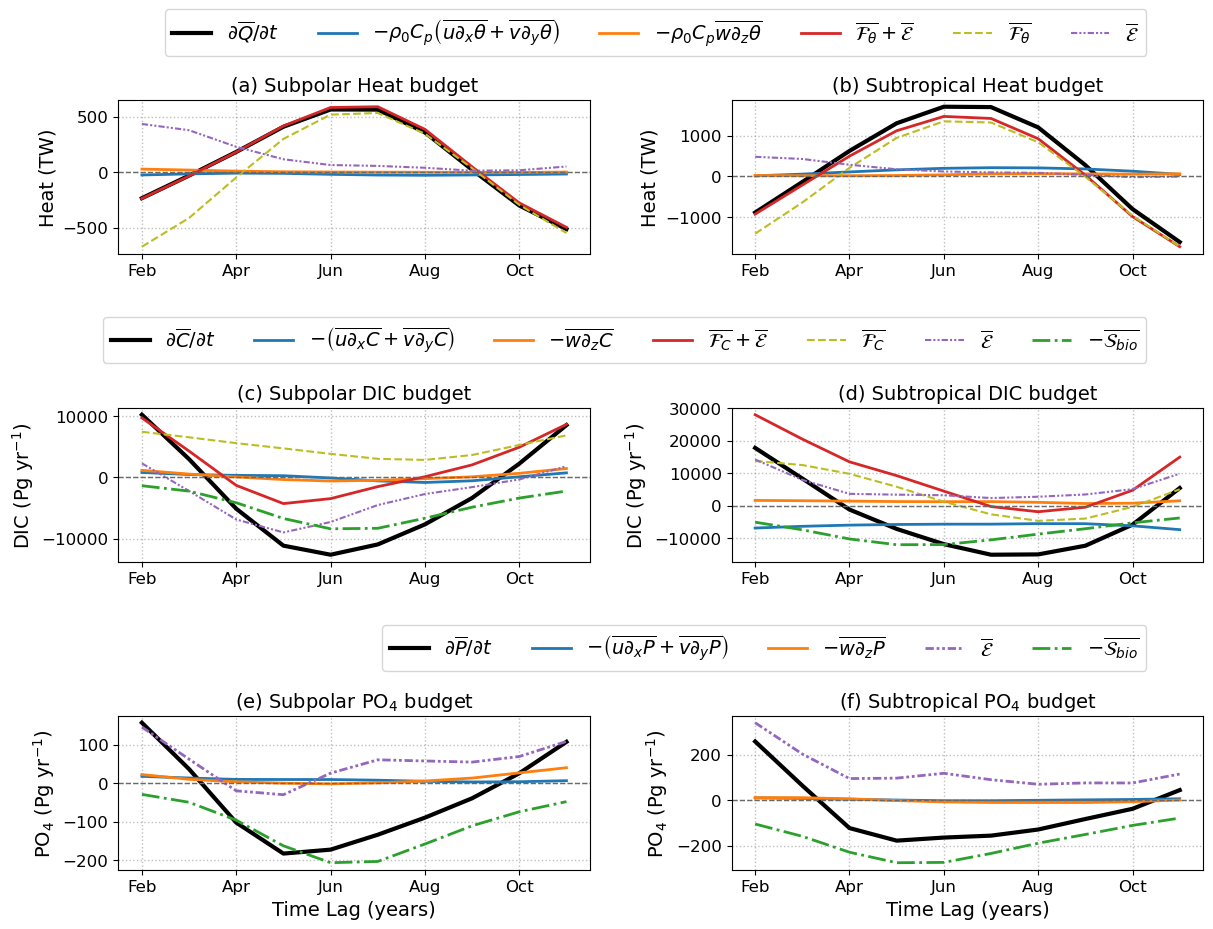

In [44]:
grid1 = plt.GridSpec(3,2, wspace=0.3, hspace=1.0)
fig = plt.figure(figsize=[14,10])

region_list = ['_North_Atlantic_Subpolar', '_North_Atlantic_Subtropical']
reg_lab = [r'Subpolar', r'Subtropical']


fac = [1000. * 1.e-15 * 3600*24*365] # convert po4 budget in Pg/year (from kg/s)

label_tend = [r'${\partial \overline{Q}/\partial t}$',
              r'${\partial \overline{C}/\partial t}$', r'${\partial \overline{P}/\partial t}$']

label_hor = [r'$-\rho_0C_p\left(\overline{u\partial_x\theta} + \overline{v\partial_y\theta} \right)$',
             r'$-\left(\overline{u\partial_xC} + \overline{v\partial_yC} \right)$',
            r'$-\left(\overline{u\partial_xP} + \overline{v\partial_yP} \right)$']
label_ver = [r'$-\rho_0C_p\overline{w\partial_z\theta}$',
             r'$-\overline{w\partial_zC}$', r'$-\overline{w\partial_zP}$']

var_list = ['thetao', 'dissic', 'po4']
fac = [4.09*1.e6/1.e12, 12./1.e3, 31./1.e3]

for i in range(0,3):
    j = 0
    for region in region_list:
        ax = fig.add_subplot(grid1[i, j])
        tmp = ((ds[var_list[i] + region] * ds['dz']).sel(lev=slice(0,100.))).sum('lev')
        tmp_dt = (tmp.isel(month=slice(2,12)) - tmp.isel(month=slice(0,10)).drop('month')) / (3600.*24.*60.)
        tmp_dt = tmp_dt* fac[i]
        ax.plot(ds['month'][0:10] + 1.0, tmp_dt, #tmp.diff('month')* fac[i] / (3600.*24.*30.), 
                lw=3., label= label_tend[i], color='black')

        tmp_hor = (((ds[var_list[i] + '_u_div_x' + region] + 
                     ds[var_list[i] + '_u_div_y' + region]) * ds['dz']).sel(lev=slice(0,100.))).sum('lev')
        tmp_hor = -tmp_hor.rolling(month = 3, center = True).mean('month')* fac[i]
        
        ax.plot(ds['month'], tmp_hor, lw=2., label= label_hor[i], color='tab:blue')
        tmp_ver = ((ds[var_list[i] + '_u_div_z' + region] * ds['dz']).sel(lev=slice(0,100.))).sum('lev')
        tmp_ver = tmp_ver.rolling(month = 3, center = True).mean('month')* fac[i]
        ax.plot(ds['month'], tmp_ver, lw=2., label= label_ver[i], color='tab:orange')

        if(var_list[i] == 'thetao'):
            tmp_flx = ds['hfds' + region].isel(lev=0).rolling(month = 3, center = True).mean('month') / 1.e12
            tmp_ent = tmp_dt.drop('month') - (tmp_flx + tmp_hor + tmp_ver).isel(month=slice(1,11))
            tmp = tmp_flx.isel(month=slice(1,11)) + tmp_ent

            ax.plot(ds['month'].isel(month=slice(1,11)), tmp, lw=2.0, 
                        label=r'$\overline{\mathcal{F}_{\theta}} + \overline{\mathcal{E}}$', color='tab:red')
            
            ax.plot(ds['month'], tmp_flx, lw=1.5, ls='--', label= r'$\overline{\mathcal{F}_{\theta}}$', color='tab:olive')
            
            ax.plot(ds['month'].isel(month=slice(1,11)), tmp_ent, ls=(0, (3, 1, 1, 1,1, 1)), 
                        lw=1.5, label=r'$\overline{\mathcal{E}}$', color='tab:purple')
            
            ax.set_ylabel(r'Heat (TW)', fontsize=14)
            ax.set_title('(' + chr(97+j) + ') ' + reg_lab[j] + ' Heat budget', fontsize=14)
            
        elif(var_list[i] == 'dissic'):
            tmp_flx = ds['fgco2' + region].isel(lev=0).rolling(month = 3, center = True).mean('month')
            tmp_bio = -ds['epc100' + region].rolling(month = 3, center = True).mean('month')* fac[i]
            tmp_ent = tmp_dt.drop('month') - (tmp_flx + tmp_hor + tmp_ver + tmp_bio).isel(month=slice(1,11))
            tmp = tmp_flx.isel(month=slice(1,11)) + tmp_ent

            ax.plot(ds['month'].isel(month=slice(1,11)), tmp, lw=2, 
                        label=r'$\overline{\mathcal{F}_{C}} + \overline{\mathcal{E}}$', color='tab:red')
            ax.plot(ds['month'], tmp_flx, lw=1.5, ls='--', label= r'$\overline{\mathcal{F}_{C}}$', color='tab:olive')
            ax.plot(ds['month'].isel(month=slice(1,11)), tmp_ent, ls=(0, (3, 1, 1, 1,1, 1)), 
                        lw=1.5, label=r'$\overline{\mathcal{E}}$', color='tab:purple')
            ax.plot(ds['month'], tmp_bio, ls='-.', 
                        lw=2., label=r'$-\overline{\mathcal{S}_{bio}}$', color='tab:green')
            ax.set_ylabel(r'DIC (Pg yr$^{-1}$)', fontsize=14)
            ax.set_title('(' + chr(99+j) + ') ' + reg_lab[j] + ' DIC budget', fontsize=14)
            
            
            
        elif(var_list[i] == 'po4'):
            tmp_bio = -ds['epp100' + region].rolling(month = 3, center = True).mean('month')* fac[i]
            tmp_ent = tmp_dt.drop('month') - (tmp_hor + tmp_ver + tmp_bio).isel(month=slice(1,11))
            ax.plot(ds['month'].isel(month=slice(1,11)), tmp_ent, ls=(0, (3, 1, 1, 1,1, 1)), 
                        lw=2., label=r'$\overline{\mathcal{E}}$', color='tab:purple')
            ax.plot(ds['month'], tmp_bio, ls='-.', color='tab:green',
                        lw=2., label=r'$-\overline{\mathcal{S}_{bio}}$')
            ax.set_ylabel(r'PO$_4$ (Pg yr$^{-1}$)', fontsize=14)
            ax.set_title('(' + chr(101+j) + ') ' + reg_lab[j] + ' PO$_4$ budget', fontsize=14)
            
        plt.xticks(fontsize = 12); plt.yticks(fontsize = 12);
        ax.axhline(y=0, ls='--', lw=1, color='dimgrey')
        ax.grid(color='gray', alpha=0.5, linestyle=':', lw=1.)
        
        if(i==2):
            ax.set_xlabel('Time Lag (years)', fontsize=14)
        if(j==1):
            plt.legend(loc='upper right', bbox_to_anchor=(.9, 1.65), ncol=7, fontsize=14);
        
        ax.set_xlim([ 1.5, 11.5]);
        plt.xticks(np.arange(2,11,2), [r'Feb', r'Apr', r'Jun', r'Aug', r'Oct'], fontsize = 12);
        
        j = j + 1

fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Seasonality_Budget.pdf', 
            dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Seasonality_Budget.png', 
            dpi=300,bbox_inches='tight');
        